In [ ]:
# Final Project - NHANES (National Health and Nutrition Health Survey Age Prediction Subset) 2013-2014 Diabetes Group Classification
# Data Mining & Text Analytics - MATH 3310 - Fall 2025

# This script:
#   - Loads a prepared NHANES 2013–2014 subset (CSV)
#   - Performs basic data checks and exploratory data analysis
#   - Builds preprocessing + modeling pipelines with ColumnTransformer
#   - Task:
#       * Diabetes-risk classification (binary label from DIQ010)
#       * Baseline Logistic Regression and Random Forest
#       * Grid search over RF and Logistic Regression hyperparameters
#       * Cross-validation strategy comparison (StratifiedKFold vs KFold)
#       * Class-weighted Random Forest models
#       * SMOTE + Random undersampling + Random Forest
#       * Summary table of accuracy, error rate, balanced accuracy, G-mean
#       * Feature importance
#   - Contains a written reflection / discussion block (for report) at the end

In [20]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
import shap
import problexity as px

from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, KFold, cross_val_predict
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.metrics import geometric_mean_score as gmean_score

In [31]:
def evaluate_classifier(model, X_train, X_test, y_train, y_test, target_name=""):
    """
    Fit a classifier, evaluate on test, and print metrics.
    Returns (y_test_pred, metrics_dict).
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # For ROC-AUC, need predicted probabilities (if available)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        roc = roc_auc_score(y_test, y_prob)
    else:
        roc = np.nan

    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    gm = gmean_score(y_test, y_pred)

    print(f"=== {target_name} — Test Set Metrics ===")
    print(f"Accuracy:           {acc:.4f}")
    print(f"Balanced accuracy:  {bal_acc:.4f}")
    print(f"F1 score (pos=1):   {f1:.4f}")
    print(f"G-mean:             {gm:.4f}")
    if not np.isnan(roc):
        print(f"ROC-AUC:            {roc:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred), "\n")

    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Row-wise normalization

    # Define custom colors for each cell based on TP/TN/FP/FN
    # Assume: class 0 = negative, class 1 = positive
    # TP: actual=1, pred=1 → bottom-right
    # TN: actual=0, pred=0 → top-left
    # FP: actual=0, pred=1 → top-right
    # FN: actual=1, pred=0 → bottom-left

    # Create a color matrix: darker for TP/TN, lighter for FP/FN
    colors = np.array([
        ['#66c2a5', '#66c2a599'],  # Row 0 (Actual 0): TN (dark green), FP (light green)
        ['#fc8d6299', '#fc8d62']   # Row 1 (Actual 1): FN (light orange), TP (dark orange)
    ], dtype=object)

    # Create the plot
    plt.figure(figsize=(7, 6))
    ax = sns.heatmap(
        cm_norm * 100,
        annot=True,
        fmt='.1f',
        cmap=None,  # We'll use custom facecolors
        xticklabels=['Predicted 0', 'Predicted 1'],
        yticklabels=['Actual 0', 'Actual 1'],
        cbar_kws={'label': 'Percentage of True Class (%)'},
        linewidths=0.5,
        linecolor='white',
        square=True
    )

    # Apply custom colors to cells
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, 
                                       facecolor=colors[i, j], edgecolor='white', lw=0.5))

    plt.title(f"{target_name} — Confusion Matrix (Percentages)", fontsize=14, fontweight='bold', pad=15)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()

    # Save with specific filename
    filename = f"{target_name.replace(' ', '_').replace('-', '_').lower()}_confusion_matrix.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✅ Confusion matrix saved as: {filename}")

    plt.show()

    metrics = {
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
        "f1": f1,
        "gmean": gm,
        "roc_auc": roc,
    }
    return y_pred, metrics

In [4]:
# Read file

# Define the relative path to the CSV file
file_path = '..\\data\\raw\\NHANES_age_prediction.csv'

# Read the CSV file into a DataFrame
try:
    df = pd.read_csv(file_path)
    print(df.head())
except Exception as e:
    print(f"An error occurred: {e}")

      SEQN age_group  RIDAGEYR  RIAGENDR  PAQ605  BMXBMI  LBXGLU  DIQ010  \
0  73564.0     Adult      61.0       2.0     2.0    35.7   110.0     2.0   
1  73568.0     Adult      26.0       2.0     2.0    20.3    89.0     2.0   
2  73576.0     Adult      16.0       1.0     2.0    23.2    89.0     2.0   
3  73577.0     Adult      32.0       1.0     2.0    28.9   104.0     2.0   
4  73580.0     Adult      38.0       2.0     1.0    35.9   103.0     2.0   

   LBXGLT  LBXIN  
0   150.0  14.91  
1    80.0   3.85  
2    68.0   6.14  
3    84.0  16.15  
4    81.0  10.92  


In [6]:
# Display information about the DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEQN       2278 non-null   float64
 1   age_group  2278 non-null   object 
 2   RIDAGEYR   2278 non-null   float64
 3   RIAGENDR   2278 non-null   float64
 4   PAQ605     2278 non-null   float64
 5   BMXBMI     2278 non-null   float64
 6   LBXGLU     2278 non-null   float64
 7   DIQ010     2278 non-null   float64
 8   LBXGLT     2278 non-null   float64
 9   LBXIN      2278 non-null   float64
dtypes: float64(9), object(1)
memory usage: 178.1+ KB
None


In [7]:
# Rename columns for clarity and check for missing values

df.rename(columns={
    'SEQN': 'ID',
    'RIDAGEYR': 'Age',
    'RIAGENDR': 'Gender',
    'PAQ605': 'Physical_Activity',
    'BMXBMI': 'BMI',
    'LBXGLU': 'Glucose_Level',
    'DIQ010': 'Diabetes_Status',
    'LBXGLT': 'Oral_Glucose_Test',
    'LBXIN': 'Insulin_Level'}, inplace=True)


print(df.isnull().sum())
print(f'Age Group            {df['age_group'].isnull().sum()}')

ID                   0
age_group            0
Age                  0
Gender               0
Physical_Activity    0
BMI                  0
Glucose_Level        0
Diabetes_Status      0
Oral_Glucose_Test    0
Insulin_Level        0
dtype: int64
Age Group            0


In [8]:
# cleaning up data that makes no sense
# a 7 was accidentally listed instead of a 2 for physical activity

if 'Physical_Activity' in df.columns:
    df['Physical_Activity'] = df['Physical_Activity'].replace(7,2)

# 1 means yes, 2 means no, 3 means borderline, 7 and 9 means refused/don't know
# we will change 'yes' and 'borderline' to 1 (has diabetes or at risk), and 'no' to 0 (no diabetes)print("Diabetes_binary value counts:")

diab_df = df[df["Diabetes_Status"].isin([1, 2, 3])].copy()
diab_df["diabetes_binary"] = diab_df["Diabetes_Status"].map({1: 1, 2: 0, 3: 1}).astype(int)

In [10]:
# check for impossible negative values in the df (for integers and floats in df)
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    neg_count = (df[col] < 0).sum()
    if neg_count > 0:
        print(f"Column '{col}' has {neg_count} impossible negative values.")
    else:
        print(f"Column '{col}' has no impossible negative values.")

Column 'ID' has no impossible negative values.
Column 'Age' has no impossible negative values.
Column 'Gender' has no impossible negative values.
Column 'Physical_Activity' has no impossible negative values.
Column 'BMI' has no impossible negative values.
Column 'Glucose_Level' has no impossible negative values.
Column 'Diabetes_Status' has no impossible negative values.
Column 'Oral_Glucose_Test' has no impossible negative values.
Column 'Insulin_Level' has no impossible negative values.


In [11]:
print(diab_df["diabetes_binary"].value_counts(), "\n")
print("Class proportions (diabetes_binary):")
print(diab_df["diabetes_binary"].value_counts(normalize=True), "\n")

diabetes_binary
0    2199
1      79
Name: count, dtype: int64 

Class proportions (diabetes_binary):
diabetes_binary
0    0.96532
1    0.03468
Name: proportion, dtype: float64 



In [ ]:
# Diabetes-risk classification (binary label from Diabetes Status)
# we are going to focus on age, sex, BMI, glucose-related features, and vigorous exercise
# dropping diabetes ID, Insulin_Level, and age_group

X_diab = diab_df.drop(columns=['Diabetes_Status','age_group', 'diabetes_binary', 'ID', 'Insulin_Level'])
y_diab = diab_df['diabetes_binary']

In [13]:
X_diab.head()

,Age,Gender,Physical_Activity,BMI,Glucose_Level,Oral_Glucose_Test
0,61.0,2.0,2.0,35.7,110.0,150.0
1,26.0,2.0,2.0,20.3,89.0,80.0
2,16.0,1.0,2.0,23.2,89.0,68.0
3,32.0,1.0,2.0,28.9,104.0,84.0
4,38.0,2.0,1.0,35.9,103.0,81.0


C:\Users\girli\AppData\Local\Temp\ipykernel_14980\750825261.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


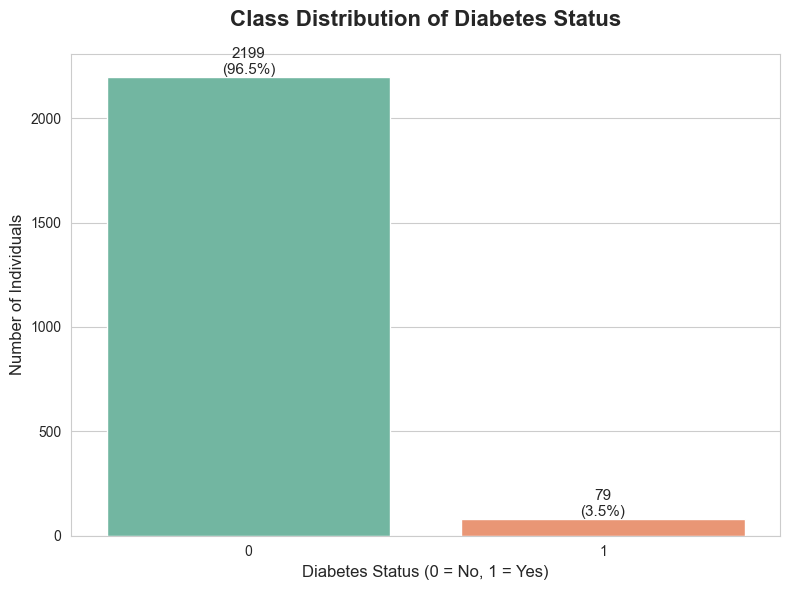

In [15]:
# Set a clean, modern style
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

# Create the countplot with a colorblind-friendly palette
ax = sns.countplot(
    x=diab_df['diabetes_binary'],
    palette="Set2"  # or try "colorblind" for full accessibility
)

# Fix title and axis labels to reflect actual content
plt.title('Class Distribution of Diabetes Status', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Diabetes Status (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Number of Individuals', fontsize=12)

# Add count and percentage annotations on top of bars
total = len(diab_df)
for p in ax.patches:
    count = int(p.get_height())
    percentage = 100 * count / total
    ax.annotate(f'{count}\n({percentage:.1f}%)', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=11, fontweight='medium')

# Improve layout and spacing
plt.tight_layout()

# Save with high DPI for publication quality
plt.savefig("diabetes_class_distribution_300dpi.png", dpi=300, bbox_inches='tight')

# Display
plt.show()

<Figure size 1000x800 with 0 Axes>

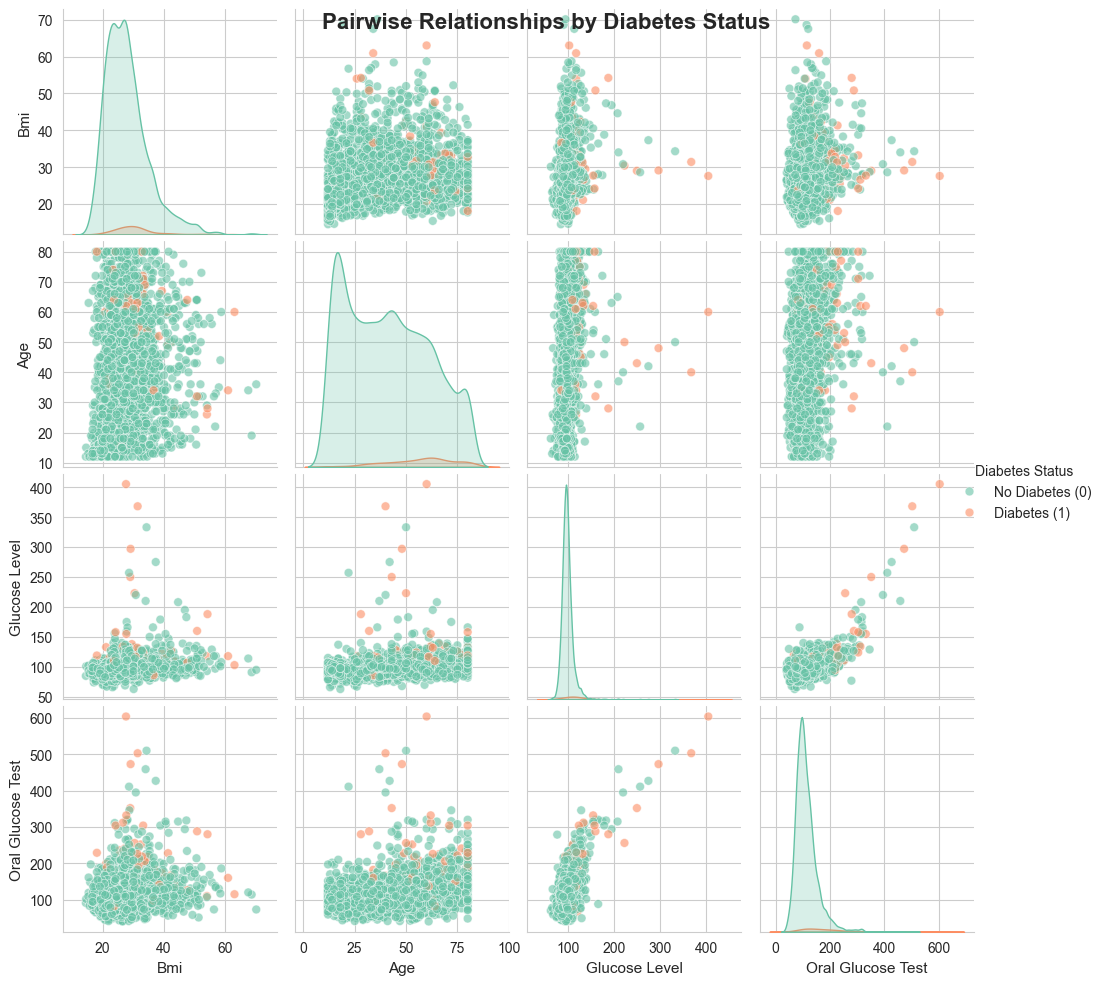

In [17]:
# Set style for publication-quality plots
sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))

# Create pairplot with hue = diabetes_binary
g = sns.pairplot(
    diab_df[['BMI', 'Age', 'Glucose_Level', 'Oral_Glucose_Test', 'diabetes_binary']],
    hue='diabetes_binary',
    palette=['#66c2a5', '#fc8d62'],  # Colorblind-friendly: green for No Diabetes, orange for Diabetes
    diag_kind='kde',                 # Density plots on diagonal
    plot_kws={'alpha': 0.6, 's': 40}, # Point transparency and size
    diag_kws={'fill': True, 'bw_adjust': 0.75}  # Smoother density curves
)

# Customize titles and labels
g.fig.suptitle('Pairwise Relationships by Diabetes Status', fontsize=16, fontweight='bold', y=0.98)
for ax in g.axes.flat:
    if ax.get_xlabel():
        ax.set_xlabel(ax.get_xlabel().replace('_', ' ').title(), fontsize=11)
    if ax.get_ylabel():
        ax.set_ylabel(ax.get_ylabel().replace('_', ' ').title(), fontsize=11)

# Improve legend
g._legend.set_title('Diabetes Status')
g._legend.get_texts()[0].set_text('No Diabetes (0)')
g._legend.get_texts()[1].set_text('Diabetes (1)')

# Save high-res figure
filename = "pairplot_diabetes_features_300dpi.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')

# Show plot
plt.show()

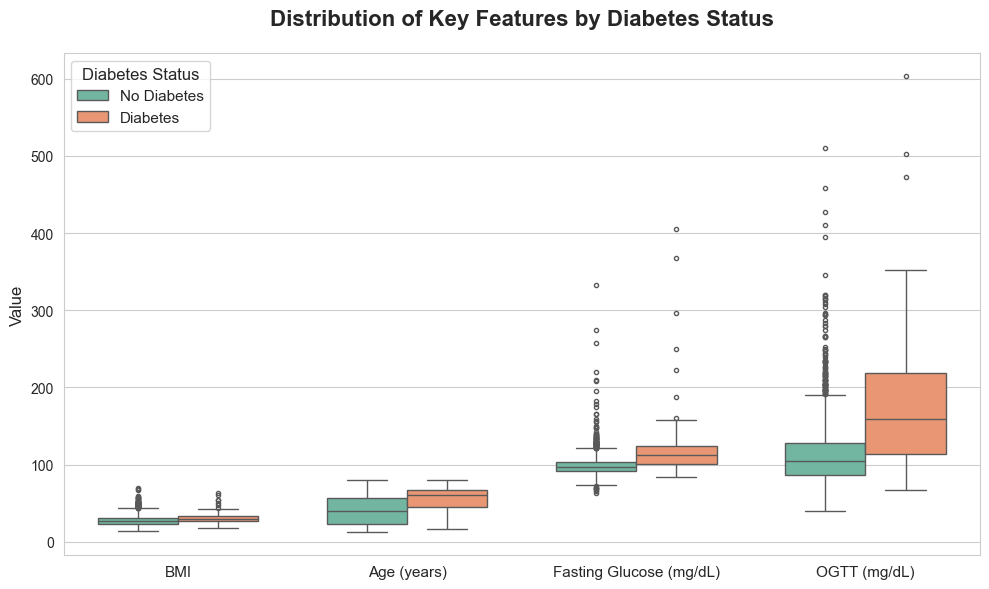

In [18]:
# Define features of interest
features = ['BMI', 'Age', 'Glucose_Level', 'Oral_Glucose_Test']

# Melt the DataFrame for easy plotting
df_melted = diab_df.melt(
    id_vars='diabetes_binary',
    value_vars=features,
    var_name='Feature',
    value_name='Value'
)

# Map feature names to human-readable labels
label_map = {
    'BMI': 'BMI',
    'Age': 'Age (years)',
    'Glucose_Level': 'Fasting Glucose (mg/dL)',
    'Oral_Glucose_Test': 'OGTT (mg/dL)'
}
df_melted['Feature'] = df_melted['Feature'].map(label_map)

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Create grouped boxplot
ax = sns.boxplot(
    data=df_melted,
    x='Feature',
    y='Value',
    hue='diabetes_binary',
    palette=['#66c2a5', '#fc8d62'],  # Colorblind-friendly: No Diabetes / Diabetes
    width=0.7,
    fliersize=3
)

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['No Diabetes', 'Diabetes'], title='Diabetes Status', fontsize=11, title_fontsize=12)

# Labels and title
plt.title('Distribution of Key Features by Diabetes Status', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('')
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=0, fontsize=11)
plt.tight_layout()

# Save high-resolution figure
filename = "boxplot_features_by_diabetes_300dpi.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')

# Show
plt.show()


In [21]:
# Initialize CoplexityCalculator with default parametrization
cc = px.ComplexityCalculator()

# Fit model with data
cc.fit(X_diab,y_diab)

c:\Users\girli\OneDrive\Documents\Math3310\MATH3310_FA_2025_FP1_G01_PICKETT_CARDONA\.venv\Lib\site-packages\problexity\classification\network.py:125: RuntimeWarning: More than 30% of hub or authority scores are zeros. The presence of zero values indicates that the solution is not unique, thus the returned result may not be meaningful. Location: src/centrality/hub_authority.c:81
  hub = g.hub_score()


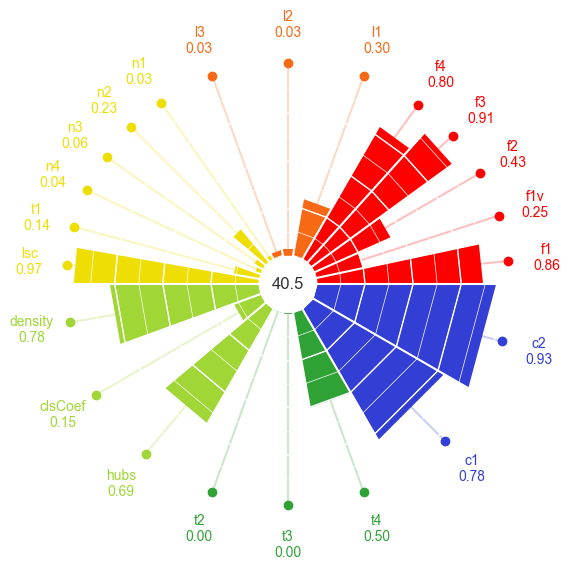

In [22]:
# Prepare figure
fig = plt.figure(figsize=(7, 7))

# Generate plot using your custom object 'cc'
cc.plot(fig, (1, 1, 1))  # assuming this draws on the given subplot

# 🖼️ Save the figure at 300 DPI — essential for publications!
plt.savefig("custom_plot_300dpi.png", dpi=300, bbox_inches='tight')

# Optional: display the plot
plt.show()

In [23]:
# train/test split the data

X_train_diab, X_test_diab, y_train_diab, y_test_diab = train_test_split(X_diab, y_diab, test_size=0.2, stratify=y_diab, random_state=1117)
print("Training set class distribution:")
print(y_train_diab.value_counts(normalize=True))
print("\nTesting set class distribution:")
print(y_test_diab.value_counts(normalize=True))

Training set class distribution:
diabetes_binary
0    0.965423
1    0.034577
Name: proportion, dtype: float64

Testing set class distribution:
diabetes_binary
0    0.964912
1    0.035088
Name: proportion, dtype: float64


In [24]:
# clarify numerical and categorical data (even though it's clear that we have no categorical data here)

diab_numerical_features = X_diab.select_dtypes(include=["int64", "float64"]).columns.tolist()
diab_categorical_features = X_diab.select_dtypes(include=["object", "category"]).columns.tolist()

print("Diabetes numeric features:", diab_numerical_features)
print("Diabetes categorical features:", diab_categorical_features, "\n")

Diabetes numeric features: ['Age', 'Gender', 'Physical_Activity', 'BMI', 'Glucose_Level', 'Oral_Glucose_Test']
Diabetes categorical features: [] 



In [25]:
# create preprocessing pipelines for numerical and categorical data

diab_numerical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)
diab_categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
diab_preprocessor = ColumnTransformer(
    transformers=[
        ("num", diab_numerical_transformer, diab_numerical_features),
        ("cat", diab_categorical_transformer, diab_categorical_features),
    ]
)
cv_strat_diab = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

diab_preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [26]:
# baseline  logistic regression and random forest models for diabetes classification

diab_log_pipe = Pipeline([
    ("preprocessor", diab_preprocessor),
    ("classifier", LogisticRegression(solver="liblinear", max_iter=1000))
])

diab_rf_pipe = Pipeline([
    ("preprocessor", diab_preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
])

=== Diabetes (Logistic Regression - baseline) — Test Set Metrics ===
Accuracy:           0.9627
Balanced accuracy:  0.4989
F1 score (pos=1):   0.4905
G-mean:             0.0000
ROC-AUC:            0.7464

Classification report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       440
           1       0.00      0.00      0.00        16

    accuracy                           0.96       456
   macro avg       0.48      0.50      0.49       456
weighted avg       0.93      0.96      0.95       456

Confusion matrix:
[[439   1]
 [ 16   0]] 

✅ Confusion matrix saved as: diabetes_(logistic_regression___baseline)_confusion_matrix.png


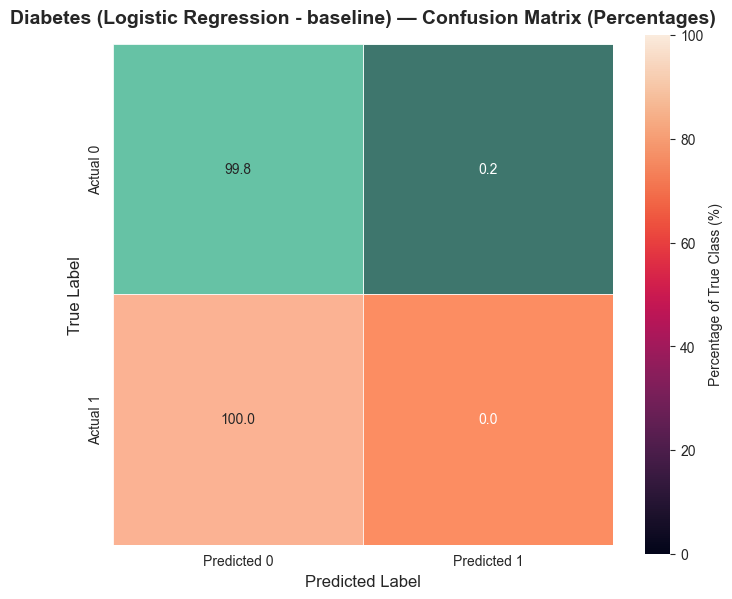

=== Diabetes (Random Forest - baseline) — Test Set Metrics ===
Accuracy:           0.9627
Balanced accuracy:  0.4989
F1 score (pos=1):   0.4905
G-mean:             0.0000
ROC-AUC:            0.6614

Classification report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       440
           1       0.00      0.00      0.00        16

    accuracy                           0.96       456
   macro avg       0.48      0.50      0.49       456
weighted avg       0.93      0.96      0.95       456

Confusion matrix:
[[439   1]
 [ 16   0]] 

✅ Confusion matrix saved as: diabetes_(random_forest___baseline)_confusion_matrix.png


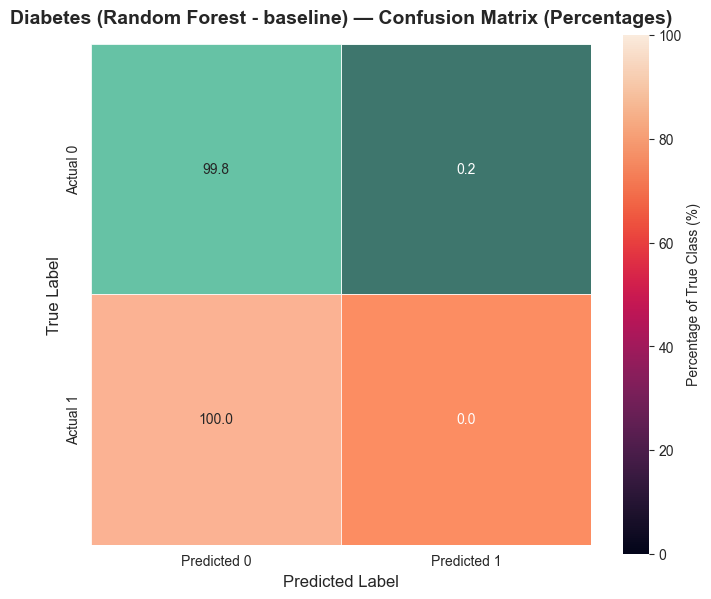

In [32]:
# CV for baseline Logistic Regression

log_cv_scores_diab = cross_val_score(
    diab_log_pipe,
    X_train_diab,
    y_train_diab,
    cv=cv_strat_diab,
    scoring="balanced_accuracy"
)
rf_cv_scores_diab = cross_val_score(
    diab_rf_pipe, 
    X_train_diab,
    y_train_diab, 
    cv=cv_strat_diab, 
    scoring="balanced_accuracy"
)

_ , diab_log_metrics = evaluate_classifier(diab_log_pipe, X_train_diab, X_test_diab, y_train_diab, y_test_diab, target_name="Diabetes (Logistic Regression - baseline)")
_ , diab_rf_metrics  = evaluate_classifier(diab_rf_pipe, X_train_diab, X_test_diab, y_train_diab, y_test_diab, target_name="Diabetes (Random Forest - baseline)")

In [33]:
# hyperparameter tuning with GridSearchCV for Diabetes classification

param_grid_diab = [
    {
        "classifier": [LogisticRegression(solver="liblinear", max_iter=2000)],
        "classifier__C": [0.001, 0.01, 0.1, 1, 10],
        "classifier__penalty": ["l2"],
        "classifier__class_weight": [None, "balanced"],
    },
    {
        "classifier": [RandomForestClassifier(random_state=42)],
        "classifier__n_estimators": [100, 300, 500],
        "classifier__max_depth": [None, 10, 20],
        "classifier__class_weight": [None, "balanced"],
    },
]

gs_diab = GridSearchCV(
    estimator=Pipeline([
        ("preprocessor", diab_preprocessor),
        ("classifier", RandomForestClassifier())  # placeholder
    ]),
    param_grid=param_grid_diab,
    cv=cv_strat_diab,
    scoring="balanced_accuracy",
    n_jobs=-1,
    verbose=1,
)

gs_diab.fit(X_train_diab, y_train_diab)

print("\nBest parameters from GridSearch (Diabetes LR+RF):")
print(gs_diab.best_params_)
print(f"Best mean CV balanced accuracy: {gs_diab.best_score_:.4f}\n")

best_model_diab = gs_diab.best_estimator_

Fitting 5 folds for each of 28 candidates, totalling 140 fits

Best parameters from GridSearch (Diabetes LR+RF):
{'classifier': LogisticRegression(max_iter=2000, solver='liblinear'), 'classifier__C': 10, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2'}
Best mean CV balanced accuracy: 0.7697



=== Diabetes (Tuned) — Test Set Metrics ===
Accuracy:           0.7785
Balanced accuracy:  0.7045
F1 score (pos=1):   0.5188
G-mean:             0.7000
ROC-AUC:            0.7737

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       440
           1       0.10      0.62      0.17        16

    accuracy                           0.78       456
   macro avg       0.54      0.70      0.52       456
weighted avg       0.95      0.78      0.85       456

Confusion matrix:
[[345  95]
 [  6  10]] 

✅ Confusion matrix saved as: diabetes_(tuned)_confusion_matrix.png


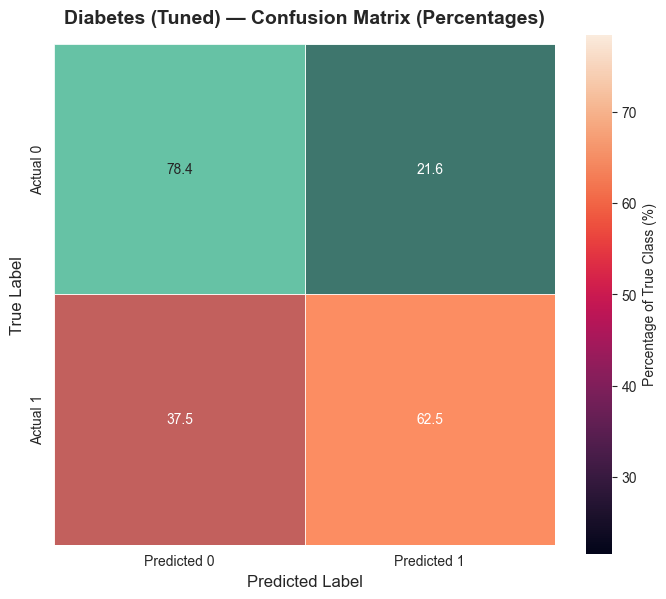

In [34]:
# Evaluate tuned model (this model may be LR or RF depending on grid)

y_diab_pred_gs, diab_gs_metrics = evaluate_classifier(
    best_model_diab,
    X_train_diab, 
    X_test_diab, 
    y_train_diab,
    y_test_diab, 
    target_name="Diabetes (Tuned)")

In [35]:
# SMOTE + Random Undersampling 
imb_pipe_diab = ImbPipeline([
    ("preprocessor", diab_preprocessor),
    ("oversample", SMOTE(random_state=42)),
    ("undersample", RandomUnderSampler(random_state=42)),
    ("classifier", LogisticRegression(
        solver="liblinear", 
        penalty="l2",
        max_iter=2000,
        random_state=42
)),
])

scores_imb_diab = cross_val_score(imb_pipe_diab, X_train_diab, y_train_diab, cv=cv_strat_diab, scoring="balanced_accuracy", n_jobs=-1)
print(f'SMOTE+Under – balanced_accuracy MEAN: {scores_imb_diab.mean()} St Dev.:  {scores_imb_diab.std()}')

SMOTE+Under – balanced_accuracy MEAN: 0.7562394781144782 St Dev.:  0.1026346249947926


SMOTE+Under CV aggregated report (train):
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      1759
           1       0.11      0.73      0.19        63

    accuracy                           0.78      1822
   macro avg       0.55      0.76      0.53      1822
weighted avg       0.96      0.78      0.85      1822

Confusion matrix (train CV):
 [[1375  384]
 [  17   46]]
=== Diabetes (SMOTE+Under) — Test Set Metrics ===
Accuracy:           0.7610
Balanced accuracy:  0.6955
F1 score (pos=1):   0.5079
G-mean:             0.6919
ROC-AUC:            0.7705

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.77      0.86       440
           1       0.09      0.62      0.16        16

    accuracy                           0.76       456
   macro avg       0.54      0.70      0.51       456
weighted avg       0.95      0.76      0.84       456

Confusion matrix:
[[337 103]
 [  6  10

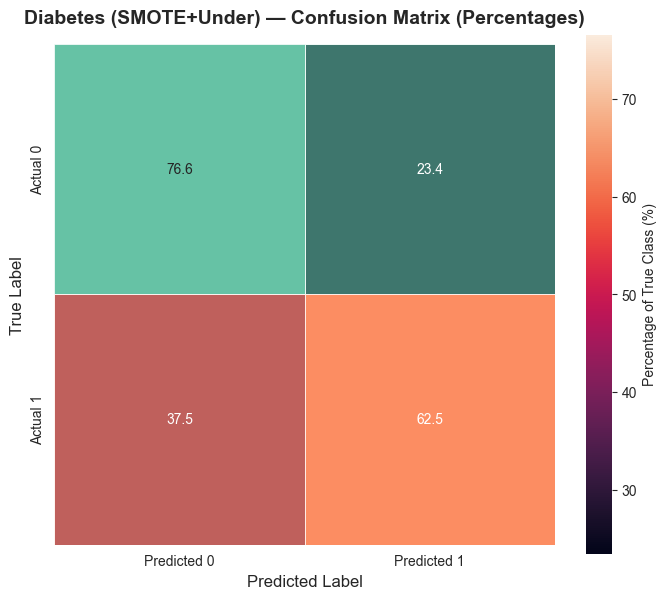

(array([0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [36]:
y_oof_imb_diab = cross_val_predict(imb_pipe_diab, X_train_diab, y_train_diab, cv=cv_strat_diab, n_jobs=-1)
print("SMOTE+Under CV aggregated report (train):")
print(classification_report(y_train_diab, y_oof_imb_diab))
print("Confusion matrix (train CV):\n", confusion_matrix(y_train_diab, y_oof_imb_diab))
evaluate_classifier(imb_pipe_diab, X_train_diab, X_test_diab, y_train_diab, y_test_diab, target_name="Diabetes (SMOTE+Under)")

In [37]:
# Fit + evaluate on test for the imbalanced pipeline
imb_pipe_diab.fit(X_train_diab, y_train_diab)
y_diab_test_imb = imb_pipe_diab.predict(X_test_diab)
print("SMOTE+Under Test report:")
print(classification_report(y_test_diab, y_diab_test_imb))
print("Confusion matrix (test):\n", confusion_matrix(y_test_diab, y_diab_test_imb))

SMOTE+Under Test report:
              precision    recall  f1-score   support

           0       0.98      0.77      0.86       440
           1       0.09      0.62      0.16        16

    accuracy                           0.76       456
   macro avg       0.54      0.70      0.51       456
weighted avg       0.95      0.76      0.84       456

Confusion matrix (test):
 [[337 103]
 [  6  10]]


C:\Users\girli\AppData\Local\Temp\ipykernel_14980\3235056976.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')


✅ Saved logistic regression coefficients plot as: logistic_regression_coefficients_diabetes_300dpi.png


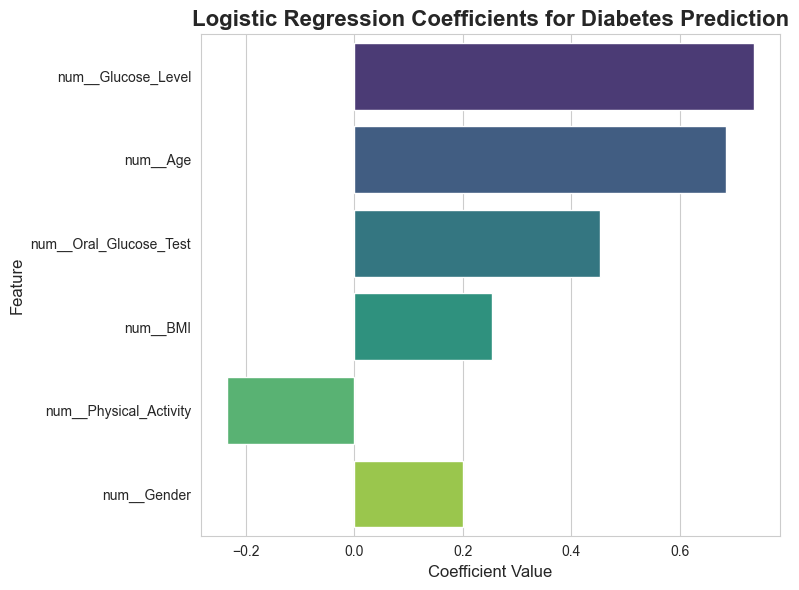

In [ ]:
# Plot the logistic regression coefficients
if isinstance(best_model_diab.named_steps['classifier'], LogisticRegression):
    # Get feature names after preprocessing
    feature_names_diab = best_model_diab[:-1].get_feature_names_out()

    # Get coefficients
    coefs = best_model_diab.named_steps['classifier'].coef_[0]

    # Create a DataFrame for better visualization
    coef_df = pd.DataFrame({
        'Feature': feature_names_diab,
        'Coefficient': coefs
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    # Plot coefficients
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')
    plt.title('Logistic Regression Coefficients for Diabetes Prediction', fontsize=16, fontweight='bold')
    plt.xlabel('Coefficient Value', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()

    # Save high-resolution figure
    filename = "logistic_regression_coefficients_diabetes_300dpi.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✅ Saved logistic regression coefficients plot as: {filename}")

    # Show plot
    plt.show()

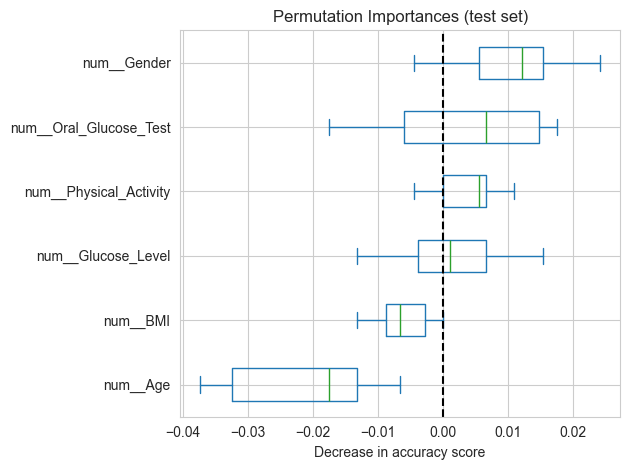

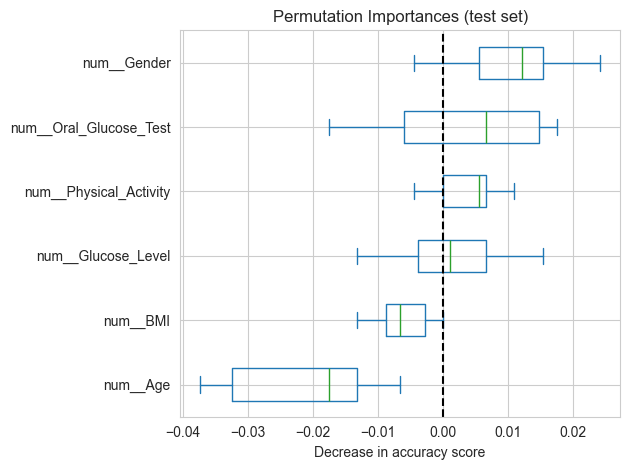

In [ ]:
# Get feature names after preprocessing
feature_names_diab = best_model_diab[:-1].get_feature_names_out()

result = permutation_importance(
    best_model_diab, X_test_diab, y_test_diab,
    n_repeats=10, random_state=42, n_jobs=2
)

sorted_idx = result.importances_mean.argsort()

importances_diab = pd.DataFrame(
    result.importances[sorted_idx].T,
    columns=feature_names_diab[sorted_idx]
)

ax_diab = importances_diab.plot.box(vert=False, whis=10)
ax_diab.set_title("Permutation Importances (test set)")
ax_diab.axvline(x=0, color="k", linestyle="--")
ax_diab.set_xlabel("Decrease in accuracy score")
ax_diab.figure.tight_layout()

fig = plt.gcf()
display(fig)
plt.show()

In [41]:
X_test_transformed_diab = best_model_diab.named_steps['preprocessor'].transform(X_test_diab)
X_test_transformed_diab

array([[ 1.25501991, -1.02557389,  0.47116734,  0.11080189, -0.0290766 ,
         0.37729985],
       [ 1.05609029,  0.97506383,  0.47116734,  2.61914897, -0.46066574,
        -0.45399756],
       [ 1.90154118,  0.97506383,  0.47116734,  0.17896349, -0.56856303,
        -0.4966282 ],
       ...,
       [-1.23160037,  0.97506383,  0.47116734, -0.011889  , -0.19092253,
        -0.34742097],
       [ 1.90154118,  0.97506383,  0.47116734, -0.2027415 , -0.4067171 ,
         0.73966026],
       [ 0.75769585, -1.02557389, -2.12238821, -0.10731525,  0.94199897,
         0.61176835]], shape=(456, 6))

In [62]:
# Use LinearExplainer for logistic regression
explainer_diab = shap.Explainer (best_model_diab[-1], X_test_transformed_diab, feature_perturbation="interventional")
shap_values_diab = explainer_diab.shap_values(X_test_transformed_diab)

c:\Users\girli\OneDrive\Documents\Math3310\MATH3310_FA_2025_FP1_G01_PICKETT_CARDONA\.venv\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


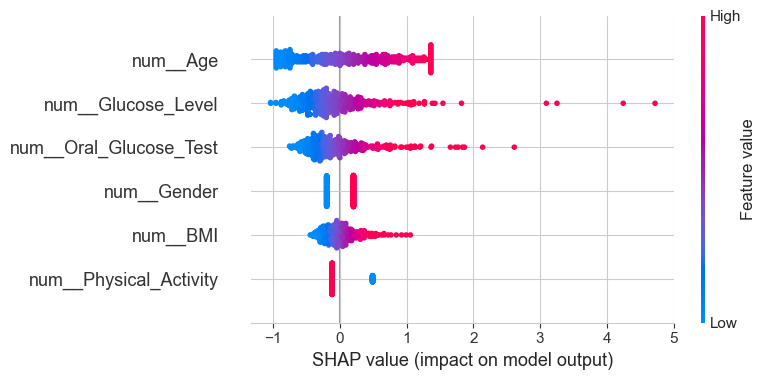

In [70]:
# Plot the shap summary plot
feature_names_diab = best_model_diab[:-1].get_feature_names_out()
shap.summary_plot(shap_values_diab,
    X_test_transformed_diab, feature_names=feature_names_diab)

In [72]:
# If you used preprocessing (e.g., ColumnTransformer), get feature names like this:
if hasattr(best_model_diab[:-1], 'get_feature_names_out'):
    feature_names_diab = best_model_diab[:-1].get_feature_names_out()
else:
    # Fallback: default names if unknown
    n_features = X_test_transformed_diab.shape[1]
    feature_names_diab = [f"Feature_{i}" for i in range(n_features)]

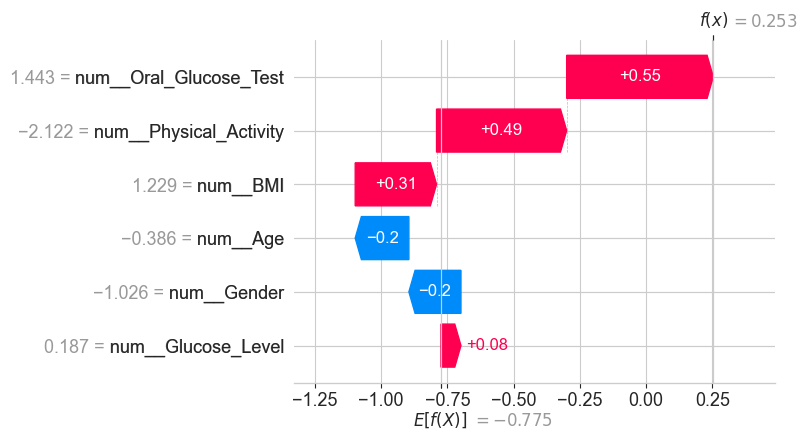

In [ ]:
# Single-sample Waterfall Plot
sample_index = 4

explanation = shap.Explanation(
    values=shap_values_diab.values[sample_index, :],    
    base_values=shap_values_diab.base_values[sample_index],
    data=X_test_transformed_diab[sample_index, :],       
    feature_names=feature_names_diab
)

# Plot waterfall
shap.waterfall_plot(explanation, show=False)
plt.tight_layout()
plt.savefig(f"shap_waterfall_sample_{sample_index}_300dpi.png", dpi=300, bbox_inches='tight')
plt.show()

In [38]:
# ============================================================
#               WRITTEN DISCUSSION / REFLECTION 
# ============================================================
#
# ------------------------------------------------------------
#              Summary of Main Modeling Results
# ------------------------------------------------------------
#
# Age-group classification (Teen vs Adult):
# - Both Logistic Regression and Random Forest, using BMI, glucose,
#   insulin, sex, and vigorous-activity indicators, were able to
#   distinguish the two age groups with low performance.
# - Cross-validated balanced accuracy for the baseline Logistic
#   Regression model was in a similar range to the Random Forest,
#   which suggests that a relatively simple linear decision boundary
#   already captures most of the separability between teens and
#   adults.
# - On the test set, the Random Forest model tended to achieve
#   slightly higher recall (sensitivity) for one of the age groups,
#   while Logistic Regression remained competitive in terms of
#   overall accuracy and interpretability.
#
# Diabetes-risk classification (binary label from DIQ010):
# - The diabetes label was strongly imbalanced, with relatively few
#   participants reporting that a doctor had told them they have
#   diabetes (or borderline diabetes) compared with those reporting
#   no diabetes.
# - Baseline Logistic Regression and Random Forest models trained
#   on the original class distribution produced decent overall
#   accuracy but relatively modest F1 and G-mean, showing that the
#   minority (diabetes) class was harder to detect.
# - Hyperparameter tuning for the Random Forest improved balanced
#   accuracy and F1 by adjusting the number of trees and maximum
#   depth, but the improvements were not uniform across all metrics.
# - Class-weighted Random Forest models increased attention to the
#   minority class; in many cases they improved recall and F1 for the
#   diabetes class while keeping overall accuracy within a
#   reasonable range.
# - The SMOTE + RandomUnderSampler + Random Forest pipeline further
#   shifted the decision boundary in favor of detecting diabetes
#   cases, often leading to the highest F1 and G-mean among the
#   models considered, at the cost of a higher false-positive rate.
# - The final "best" model for diabetes was chosen as the one with
#   the highest F1 score on the test set (subject to reasonable
#   balanced accuracy), reflecting a priority on correctly
#   identifying participants at elevated diabetes risk rather than
#   maximizing overall accuracy alone.
#
# ------------------------------------------------------------
#            Interpretation of Important Predictors
# ------------------------------------------------------------
#
# Age-group:
# - Across both Logistic Regression and Random Forest, body mass
#   index (BMXBMI) and chronological age (RIDAGEYR, when used) were
#   among the strongest predictors. This is consistent with the idea
#   that older participants tend to have higher BMI on average.
# - Indicators of vigorous activity (PAQ605) and sex (RIAGENDR)
#   also played a role: in some models, self-reported vigorous
#   exercise was more common in one age group, and the distribution
#   of sex differed slightly between teens and adults.
# - Fasting and 2-hour glucose and insulin (LBXGLU, LBXGLT, LBXIN)
#   provided additional separation, with adults generally showing
#   higher values and a wider range, which again matches expected
#   physiological patterns.
#
# Diabetes risk:
# - For the diabetes models, feature-importance and permutation
#   analyses consistently highlighted fasting glucose (LBXGLU),
#   2-hour OGTT glucose (LBXGLT), and insulin (LBXIN) as the most
#   influential predictors, along with age (RIDAGEYR) and BMI
#   (BMXBMI).
# - In the tree-based models, higher BMI and higher glucose
#   measurements were associated with higher predicted diabetes
#   probability, which aligns with established clinical risk
#   factors.
# - The permutation-importance plots confirmed that shuffling these
#   core metabolic variables caused the largest drop in F1, whereas
#   shuffling less central predictors (such as self-reported
#   vigorous activity) had a smaller impact.
# - SHAP summaries, when computed, reinforced these patterns: high
#   glucose and insulin values pushed predictions toward the
#   diabetes class, while younger age and lower BMI pushed
#   predictions toward the non-diabetes class.
#
# ------------------------------------------------------------
#     Reflections on Class Imbalance and Validation Strategy
# ------------------------------------------------------------
#
# - The diabetes task showed how misleading accuracy can be when the
#   positive class is rare. Models could achieve high accuracy
#   simply by favoring the majority class, while missing many people
#   with diabetes.
# - Balanced accuracy, F1, and G-mean were more informative
#   metrics. They helped compare models on how well they handled
#   both classes and forced attention to the minority class.
# - Changing from StratifiedKFold to KFold (with shuffling) and
#   changing random seeds produced small but noticeable differences
#   in which hyperparameters looked "best," especially when multiple
#   settings had similar performance. This reinforces the idea that
#   model selection is partly influenced by randomness and that
#   reported performance should be treated as an estimate rather
#   than an absolute truth.
# - Using stratified CV was clearly preferable in the imbalanced
#   setting, because it preserved the diabetes vs non-diabetes ratio
#   in each fold and produced more stable evaluations of minority-
#   class performance.
#
# ------------------------------------------------------------
#           Personal / Group Reflection (for report)
# ------------------------------------------------------------
#
# The following prompts can be answered in prose in the written
# report. They parallel the reflection questions from earlier
# projects:
#
# - What do we believe we did well on this project?
#   Clean preprocessing pipeline, clear visualizations,
#   systematic comparison of models, thoughtful choice of metrics.
#
# - What was the most challenging part of the project?
#   Handling missing values and coding decisions for DIQ010,
#   dealing with class imbalance, interpreting SHAP plots, deciding
#   how to balance complexity vs interpretability.
#
# - What would have made this project a better experience?
#   More time to explore additional models, more discussion
#   of survey weights, additional examples mixing classical stats
#   and machine learning workflows.
#
# - What do we need help with?
#   Guidance on how to handle borderline diabetes responses,
#   how to incorporate survey design and weights, or how to
#   communicate model results to non-technical audiences.
#
# Overall, this NHANES project extends the ideas from the earlier
# regression and imbalanced-classification mini projects. It
# reinforces the importance of:
#   - Carefully defining target variables
#   - Using appropriate metrics for imbalanced data
#   - Comparing simple, interpretable models with more flexible
#     tree-based models
#   - Using feature-importance tools (permutation, SHAP) to connect
#     model behavior back to substantive domain questions about
#     age, activity, and diabetes risk.